# Optimal Growth Model using modified policy function iteration
According to Heer and Maussner, modified policy function iteration is faster than policy function iteration if grid size is reasonably large.


In [1]:
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
mutable struct Model
    # primitive parameter
    beta::Float64 #subjective discount factor
    sigma::Float64 # relative risk aversion
    delta::Float64 #depriciation rate
    alpha::Float64 # capital share

    # discretize asset space
    agrid::Array{Float64,1}
end


function MPFI(m::Model)
    const beta = m.beta
    const sigma = m.sigma
    const alpha = m.alpha
    const delta = m.delta
    
    agrid =m.agrid
    const na = size(agrid, 1)
    
    #utility function
    u(c::Float64) = (c^(1-sigma))/(1-sigma)
    
    const penalty::Float64 = -1e10
    
    #initialize value function and so on

    util::Array{Float64,2} = zeros(na,na) # utility matrix
    reward::Array{Float64,1}  = zeros(na) # new utility using policy
    v0::Array{Float64,1} = zeros(na) # initial guess of value function
    W::Array{Float64,1} = zeros(na)
    W_new::Array{Float64,1} = zeros(na)
    pol_a::Array{Float64,1} =zeros(na) # policy function
    a_index::Array{Int64,1}=zeros(na)
    #create consuptibon and utility matrix
    for (i,today) in enumerate(agrid)
        for (j,next) in enumerate(agrid)
            c = today ^ alpha + (1.0-delta)*today - next
            if c >= 0.0
                @inbounds util[i,j] = u(c)
            else
                @inbounds util[i,j] = penalty
            end
        end
    end

    #iteration settings
    const maxiter = 1000
    const tol::Float64 =1e-5

    # Policy function iteration
    
    for iter in 1:maxiter
        # calculate temp value function
        gridstart::Int64=1 
        for i in 1:na
            vmin = penalty
            for j in gridstart:na
               @inbounds v = util[i,j] + beta*v0[j]#v[i,j] = util[i,j] + beta*v0[j]
                if v > vmin
                    vmin = copy(v)
                    gridstart = copy(j)
                end
            end
            @inbounds a_index[i] = gridstart
        end
        
        Q= spzeros(na,na)
        
        for i in 1:na
            #@inbounds pol_a[i]  = agrid[a_index[i]]
            @inbounds Q[i,a_index[i]] =1.0
            @inbounds reward[i] = u(agrid[i]^alpha + (1.0-delta)*agrid[i] - agrid[a_index[i]])#pol_a[i]) 
        end
        
        W = copy(v0)
        #W_new = similar(W)
        # modified policy iteration
        for k in 1:15
            W_new = reward +beta*Q*W
            W=copy(W_new)
        end
        
        error = maximum(abs.(W-v0)) # update error
        v0    = copy(W) # update value function
        
        if error < tol
            for i in 1:na
                @inbounds pol_a[i]  = agrid[a_index[i]]
            end
            break
        end
            
    end
    #println("iteration number is $iter")
    return(agrid,v0,pol_a)
end

MPFI (generic function with 1 method)

In [3]:
beta = 0.95 #subjective discount factor
sigma = 2.0 # relative risk aversion
delta = 0.1 #depriciation rate
alpha = 0.33 # capital share

# Steady state
aterm = 1.0/beta -(1.0 -delta)
kstar = alpha/aterm
kstar = kstar^(1.0/(1.0-alpha))

amin = 0.1 * kstar
amax = 2.0 * kstar
na   = 250

model = Model(beta, sigma, delta, alpha, linspace(amin, amax, na))

Model(0.95, 2.0, 0.1, 0.33, [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172])

In [4]:
agrid,v0,pol_a = MPFI(model)

([0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [-22.9351, -22.7698, -22.6155, -22.4701, -22.3331, -22.2037, -22.0811, -21.9646, -21.8535, -21.7473  …  -15.763, -15.7527, -15.7425, -15.7323, -15.7221, -15.712, -15.702, -15.6919, -15.682, -15.672], [0.484919, 0.509038, 0.533157, 0.581395, 0.605514, 0.629633, 0.653752, 0.677871, 0.70199, 0.726109  …  5.7911, 5.7911, 5.81522, 5.83934, 5.86346, 5.88758, 5.9117, 5.93582, 5.95994, 5.95994])

In [5]:
@time MPFI(model);

  0.010295 seconds (3.19 k allocations: 4.224 MiB)



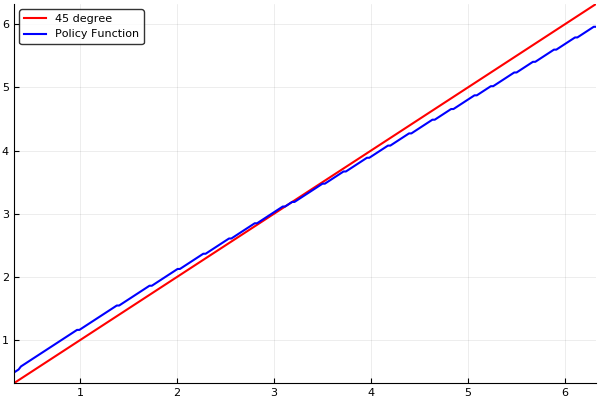

In [6]:
plot(agrid,agrid,color="red",linewidth=1.5, label="45 degree")
plot!(agrid,pol_a,color="blue",linewidth=1.5,label="Policy Function")


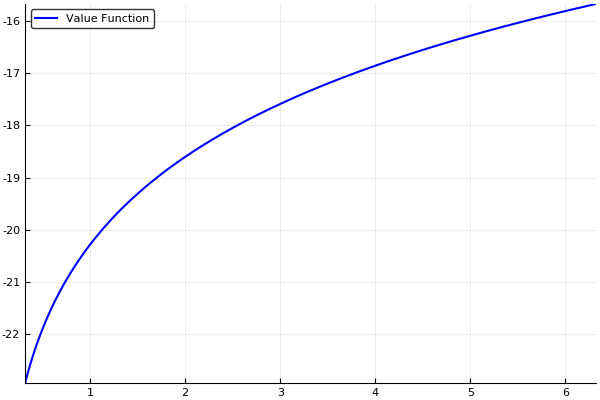

In [7]:
plot(agrid, v0, color="blue", linewidth=1.5, label="Value Function")

In [8]:
@benchmark MPFI(model)

BenchmarkTools.Trial: 
  memory estimate:  4.22 MiB
  allocs estimate:  3106
  --------------
  minimum time:     8.625 ms (0.00% GC)
  median time:      9.709 ms (0.00% GC)
  mean time:        10.296 ms (6.23% GC)
  maximum time:     18.780 ms (0.00% GC)
  --------------
  samples:          485
  evals/sample:     1

In [9]:
@code_warntype MPFI(model);

Variables:
  #self# <optimized out>
  m::Model
  j@_3::Int64
  next::Float64
  #temp#@_5 <optimized out>
  c::Float64
  #temp#@_7::Tuple{Int64,Int64}
  i@_8::Int64
  today::Float64
  #temp#@_10 <optimized out>
  #temp#@_11::Tuple{Int64,Int64}
  v::Float64
  j@_13::Int64
  #temp#@_14::Int64
  vmin::Float64
  i@_16::Int64
  #temp#@_17::Int64
  i@_18::Int64
  #temp#@_19::Int64
  k <optimized out>
  #temp#@_21::Int64
  i@_22::Int64
  #temp#@_23::Int64
  iter@_24 <optimized out>
  gridstart::Int64
  Q::SparseMatrixCSC{Float64,Int64}
  error::Float64
  #temp#@_28::Int64
  beta::Float64
  sigma::Float64
  alpha::Float64
  delta::Float64
  na::Int64
  penalty <optimized out>
  maxiter <optimized out>
  tol <optimized out>
  agrid::Array{Float64,1}
  u::#u#1{Float64}
  util <optimized out>
  reward <optimized out>
  v0::Array{Float64,1}
  W::Array{Float64,1}
  W_new::Array{Float64,1}
  pol_a <optimized out>
  a_index::Array{Int64,1}
  n@_46 <optimized out>
  n@_47 <optimized out>
  #temp#@_48::

      #temp#@_48::Float64 = (Base.Math.throw)($(QuoteNode(DomainError())))::Union{}
      goto 105
      103: 
      #temp#@_48::Float64 = SSAValue(61)
      105: 
      # meta: pop location
      # meta: pop location
      $(Expr(:inbounds, :pop))
      c::Float64 = (Base.sub_float)((Base.add_float)(#temp#@_48::Float64, (Base.mul_float)((Base.sub_float)(1.0, delta::Float64)::Float64, today::Float64)::Float64)::Float64, next::Float64)::Float64 # line 40:
      unless (Base.le_float)(0.0, c::Float64)::Bool goto 118 # line 41:
      $(Expr(:inbounds, true))
      SSAValue(17) = $(Expr(:invoke, MethodInstance for (::#u#1{Float64})(::Float64), :(u), :(c)))
      (Base.arrayset)(SSAValue(0), SSAValue(17), i@_8::Int64, j@_3::Int64)::Array{Float64,2}
      $(Expr(:inbounds, :pop))
      goto 123
      118:  # line 43:
      $(Expr(:inbounds, true))
      (Base.arrayset)(SSAValue(0), -1.0e10, i@_8::Int64, j@_3::Int64)::Array{Float64,2}
      $(Expr(:inbounds, :pop))
      123: 
      goto 75
 

In [10]:
@profile MPFI(model);
Profile.print()

7 .\task.jl:335; (::IJulia.##14#17)()
 7 ...IJulia\src\eventloop.jl:8; eventloop(::ZMQ.Socket)
  7 ...src\execute_request.jl:154; execute_request(::ZMQ.Socket, ::I...
   7 ...\Compat\src\Compat.jl:174; include_string(::Module, ::String...
    7 .\loading.jl:522; include_string(::String, ::String)
     6 .\<missing>:?; anonymous
      6 .\profile.jl:23; macro expansion
       2 .\In[2]:39; MPFI(::Model)
        2 .\math.jl:699; ^
       4 .\In[2]:81; MPFI(::Model)
        4 .\operators.jl:424; *
         4 .\arraymath.jl:45; *(::Float64, ::SparseMatrixCSC...
          1 .\broadcast.jl:455; broadcast
           1 ...\higherorderfns.jl:987; broadcast_c
          3 ...e\higherorderfns.jl:90; _noshapecheck_map(::Base.Spar...
           3 ...\higherorderfns.jl:168; _allocres
     1 .\inference.jl:2622; typeinf_ext(::Core.MethodInstan...
      1 .\inference.jl:2583; typeinf_code(::Core.MethodInst...
       1 .\inference.jl:2504; typeinf_frame(::Core.MethodIns...
        1 .\inference.jl:2787;